In [ ]:
# -------------------------------------------
# Importing necessary libraries
# -------------------------------------------

# 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
import time
import os


from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from gurobipy import Model, GRB, quicksum, QuadExpr

# -------------------------------------------
# Load dataset
# -------------------------------------------
df = pd.DataFrame(fetch_california_housing(as_frame=True).frame)
df.head(10)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
5,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25,2.697
6,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25,2.992
7,3.1200,52.0,4.797527,1.061824,1157.0,1.788253,37.84,-122.25,2.414
8,2.0804,42.0,4.294118,1.117647,1206.0,2.026891,37.84,-122.26,2.267
9,3.6912,52.0,4.970588,0.990196,1551.0,2.172269,37.84,-122.25,2.611


Total predictors: p = 8
k= 1 | Models tried:      8 | Best Train R²: 0.4764 | Best Test R²: 0.4746 | Best Train MSE: 0.7014 | Best Test MSE: 0.6896
k= 2 | Models tried:     28 | Best Train R²: 0.5468 | Best Test R²: 0.5418 | Best Train MSE: 0.6071 | Best Test MSE: 0.6013
k= 3 | Models tried:     56 | Best Train R²: 0.5896 | Best Test R²: 0.5826 | Best Train MSE: 0.5498 | Best Test MSE: 0.5479
k= 4 | Models tried:     70 | Best Train R²: 0.6070 | Best Test R²: 0.5983 | Best Train MSE: 0.5265 | Best Test MSE: 0.5272
k= 5 | Models tried:     56 | Best Train R²: 0.6081 | Best Test R²: 0.5990 | Best Train MSE: 0.5251 | Best Test MSE: 0.5263
k= 6 | Models tried:     28 | Best Train R²: 0.6090 | Best Test R²: 0.5991 | Best Train MSE: 0.5239 | Best Test MSE: 0.5262
k= 7 | Models tried:      8 | Best Train R²: 0.6093 | Best Test R²: 0.5992 | Best Train MSE: 0.5234 | Best Test MSE: 0.5261
k= 8 | Models tried:      1 | Best Train R²: 0.6093 | Best Test R²: 0.5958 | Best Train MSE: 0.5234 | Best T

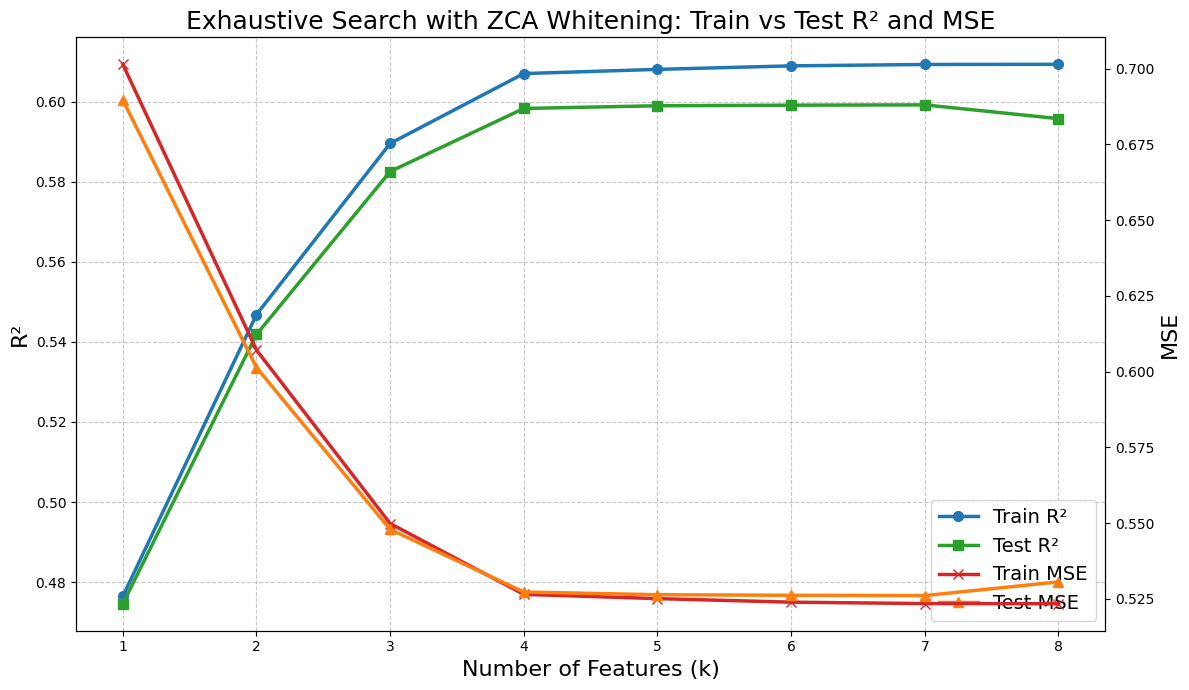

In [ ]:
# Brute force exhaustive search for best R² and MSE using OLS regression    
# Please note that this is OLS implementation just for the comparson with MIQP model in terms of models to be solved. 


# ---------------------------------
# ZCA Whitening utilities
# ---------------------------------
def compute_zca_matrix(X_train):
    X_centered = X_train - np.mean(X_train, axis=0)
    cov = np.cov(X_centered, rowvar=False)
    U, S, _ = np.linalg.svd(cov)
    epsilon = 1e-5
    ZCA_matrix = U @ np.diag(1.0 / np.sqrt(S + epsilon)) @ U.T
    return ZCA_matrix, np.mean(X_train, axis=0)

def apply_zca(X, ZCA_matrix, mean_vec):
    X_centered = X - mean_vec
    return X_centered @ ZCA_matrix

# ---------------------------------
# Combination helper 
# ---------------------------------
def combinations(iterable, k):
    pool = tuple(iterable)
    n = len(pool)
    if k > n:
        return
    indices = list(range(k))
    yield tuple(pool[i] for i in indices)
    while True:
        for i in reversed(range(k)):
            if indices[i] != i + n - k:
                break
        else:
            return
        indices[i] += 1
        for j in range(i+1, k):
            indices[j] = indices[j-1] + 1
        yield tuple(pool[i] for i in indices)

def nCr(n, r):
    from math import comb
    return comb(n, r)

# ---------------------------------
# Step 1: Prepare data
# ---------------------------------
df = pd.DataFrame(fetch_california_housing(as_frame=True).frame)

X = df.drop(columns='MedHouseVal')
y = df['MedHouseVal'].reset_index(drop=True)

# Standardize y
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_scaled, test_size=0.3, random_state=42
)

# Standardize X
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# ZCA Whitening: fit on training only
ZCA_matrix, mean_vec = compute_zca_matrix(X_train_scaled)
X_train_whitened = apply_zca(X_train_scaled, ZCA_matrix, mean_vec)
X_test_whitened = apply_zca(X_test_scaled, ZCA_matrix, mean_vec)

# Inverse-transform y for real error
y_train_true = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_test_true = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

n_train, p = X_train_whitened.shape
print(f"Total predictors: p = {p}")

# ---------------------------------
# Step 2: Exhaustive Search
# ---------------------------------
train_r2_scores = []
train_mse_scores = []
test_r2_scores = []
test_mse_scores = []
num_models_evaluated = []
total_models_tried = 0

for k in range(1, p + 1):
    best_train_r2 = -np.inf
    best_train_mse = np.inf
    best_test_r2 = -np.inf
    best_test_mse = np.inf

    for cols in combinations(range(p), k):
        X_sub_train = X_train_whitened[:, cols]
        X_sub_test = X_test_whitened[:, cols]

        model = LinearRegression().fit(X_sub_train, y_train)

        # Train prediction
        y_train_pred_scaled = model.predict(X_sub_train)
        y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
        train_r2 = r2_score(y_train_true, y_train_pred)
        train_mse = mean_squared_error(y_train_true, y_train_pred)

        # Test prediction
        y_test_pred_scaled = model.predict(X_sub_test)
        y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()
        test_r2 = r2_score(y_test_true, y_test_pred)
        test_mse = mean_squared_error(y_test_true, y_test_pred)

        # Keep best train/test for this k
        if train_mse < best_train_mse:
            best_train_mse = train_mse
            best_train_r2 = train_r2

        if test_mse < best_test_mse:
            best_test_mse = test_mse
            best_test_r2 = test_r2

        total_models_tried += 1

    train_r2_scores.append(best_train_r2)
    train_mse_scores.append(best_train_mse)
    test_r2_scores.append(best_test_r2)
    test_mse_scores.append(best_test_mse)
    num_models_evaluated.append(nCr(p, k))

    print(f"k={k:2d} | Models tried: {num_models_evaluated[-1]:6d} | "
          f"Best Train R²: {best_train_r2:.4f} | Best Test R²: {best_test_r2:.4f} | "
          f"Best Train MSE: {best_train_mse:.4f} | Best Test MSE: {best_test_mse:.4f}")

print(f"\nTotal models tried: {total_models_tried}")

# ---------------------------------
# Step 3: Plot results
# ---------------------------------
fig, ax1 = plt.subplots(figsize=(12, 7))

# R² on left axis
ax1.set_xlabel('Number of Features (k)', fontsize=16)
ax1.set_ylabel('R²', fontsize=16)
ax1.plot(range(1, p + 1), train_r2_scores, color='tab:blue',
         marker='o', markersize=7, linewidth=2.5, label='Train R²')
ax1.plot(range(1, p + 1), test_r2_scores, color='tab:green',
         marker='s', markersize=7, linewidth=2.5, label='Test R²')
ax1.tick_params(axis='y')
ax1.tick_params(axis='x')

# MSE on right axis
ax2 = ax1.twinx()
ax2.set_ylabel('MSE', fontsize=16)
ax2.plot(range(1, p + 1), train_mse_scores, color='tab:red',
         marker='x', markersize=7, linewidth=2.5, label='Train MSE')
ax2.plot(range(1, p + 1), test_mse_scores, color='tab:orange',
         marker='^', markersize=7, linewidth=2.5, label='Test MSE')
ax2.tick_params(axis='y')

# Title and legend
plt.title('Exhaustive Search with ZCA Whitening: Train vs Test R² and MSE', fontsize=18)
lines = [ax1.lines[0], ax1.lines[1], ax2.lines[0], ax2.lines[1]]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='lower right', fontsize=14)
bbox = ax1.get_position()

fig.tight_layout()
ax1.grid(True, linestyle='--', alpha=0.7)

plt.show()


In [ ]:
# -------------------------------
# Vanilla MIQP: Loop over different k
# -------------------------------

# 1) Load data & split
df = pd.DataFrame(fetch_california_housing(as_frame=True).frame)
X = df.drop(columns='MedHouseVal')
y = df['MedHouseVal'].reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 2) Standardize features & target (fit only on train)
scaler_X = StandardScaler().fit(X_train)
X_train_scaled = scaler_X.transform(X_train)
X_test_scaled  = scaler_X.transform(X_test)

scaler_y = StandardScaler().fit(y_train.values.reshape(-1,1))
y_train_scaled = scaler_y.transform(y_train.values.reshape(-1,1)).flatten()

# Prepare
X_mat_train = X_train_scaled
X_mat_test  = X_test_scaled
y_vec_train = y_train_scaled
n_train, p   = X_mat_train.shape

# 3) Loop over k
results = []

for k in range(1, p+1):  # or range(1,9) if you only want up to 8
    start = time.time()
    
    # Build MIQP
    model = Model()
    model.setParam('OutputFlag', 0)
    
    beta = model.addVars(p, lb=-GRB.INFINITY, name="beta")
    z    = model.addVars(p, vtype=GRB.BINARY, name="z")
    
    # Objective: MSE
    expr = QuadExpr()
    for i in range(n_train):
        pred_i = quicksum(X_mat_train[i, j] * beta[j] for j in range(p))
        diff   = y_vec_train[i] - pred_i
        expr.add(diff * diff)
    expr /= n_train
    model.setObjective(expr, GRB.MINIMIZE)
    
    # Constraints: beta linked to z; sum z <= k
    M_big = 50
    for j in range(p):
        model.addConstr(beta[j] <=  M_big * z[j])
        model.addConstr(beta[j] >= -M_big * z[j])
    model.addConstr(quicksum(z[j] for j in range(p)) <= k)
    
    model.optimize()
    end = time.time()
    
    # Extract solution
    selected_idx   = [j for j in range(p) if z[j].X > 0.5]
    selected_feats = [X.columns[j] for j in selected_idx]
    coeffs         = [beta[j].X       for j in selected_idx]
    
    # Build full beta vector for prediction
    beta_full = np.zeros(p)
    for idx, c in zip(selected_idx, coeffs):
        beta_full[idx] = c
    
    # Predict on test set
    y_pred_scaled = X_mat_test.dot(beta_full)
    y_pred        = scaler_y.inverse_transform(
                        y_pred_scaled.reshape(-1,1)
                    ).flatten()
    y_true        = y_test.values
    
    # Metrics
    mse_test = mean_squared_error(y_true, y_pred)
    r2_test  = r2_score(y_true, y_pred)
    runtime  = end - start
    
    # Save results
    results.append({
        'k':              k,
        'selected_feats': selected_feats,
        'coeffs':         coeffs,
        'Test MSE':       mse_test,
        'Test R²':        r2_test,
        'runtime_s':      runtime
    })

# 4) Present results
results_df = pd.DataFrame(results)
# Print summary table
print(results_df[['k','Test R²','Test MSE','runtime_s']].to_string(index=False))

# Print selected features & coefficients for each k
for row in results:
    print("\n" + "─"*80)
    print(f"k = {row['k']}")
    print(f" Selected features: {row['selected_feats']}")
    print(f" Coefficients:       {row['coeffs']}")
    print(f" Test R²:            {row['Test R²']:.4f}")
    print(f" Test MSE:           {row['Test MSE']:.4f}")
    print(f" Runtime (s):        {row['runtime_s']:.2f}")


 k  Test R²  Test MSE  runtime_s
 1 0.458859  0.709116   4.024216
 2 0.494061  0.662987   2.932453
 3 0.572055  0.560783   3.410195
 4 0.581062  0.548981   4.756412
 5 0.579028  0.551646   2.964838
 6 0.574969  0.556964   3.370268
 7 0.575788  0.555891   2.894609
 8 0.575788  0.555892   2.952019

────────────────────────────────────────────────────────────────────────────────
k = 1
 Selected features: ['MedInc']
 Coefficients:       [0.6906466061467679]
 Test R²:            0.4589
 Test MSE:           0.7091
 Runtime (s):        4.02

────────────────────────────────────────────────────────────────────────────────
k = 2
 Selected features: ['MedInc', 'HouseAge']
 Coefficients:       [0.7138433930333127, 0.1905889665892632]
 Test R²:            0.4941
 Test MSE:           0.6630
 Runtime (s):        2.93

────────────────────────────────────────────────────────────────────────────────
k = 3
 Selected features: ['MedInc', 'Latitude', 'Longitude']
 Coefficients:       [0.6076147358781624,

In [ ]:
# -------------------------------
# Experiment Case 2: MIQP with ZCA Whitening and Train/Test Split
# -------------------------------

# ZCA whitening helper
def zca_whitening(X):
    X_centered = X - np.mean(X, axis=0)
    cov = np.cov(X_centered, rowvar=False)
    U, S, _ = np.linalg.svd(cov)
    epsilon = 1e-5
    Z = U @ np.diag(1.0 / np.sqrt(S + epsilon)) @ U.T
    return X_centered @ Z

# 1) Load & split data
df = pd.DataFrame(fetch_california_housing(as_frame=True).frame)
X = df.drop(columns='MedHouseVal')
y = df['MedHouseVal'].reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 2) Standardize features on TRAIN and apply to TEST
scaler_X = StandardScaler().fit(X_train)
X_train_std = scaler_X.transform(X_train)
X_test_std  = scaler_X.transform(X_test)

# 3) ZCA-whiten TRAIN and apply same transform to TEST
X_train_zca = zca_whitening(X_train_std)
# to whiten test, center by train mean then apply train ZCA matrix
train_mean = np.mean(X_train_std, axis=0)
cov = np.cov(X_train_std - train_mean, rowvar=False)
U, S, _ = np.linalg.svd(cov)
epsilon = 1e-5
ZCA_mat = U @ np.diag(1.0 / np.sqrt(S + epsilon)) @ U.T
X_test_zca = (X_test_std - train_mean) @ ZCA_mat

# 4) Standardize target on TRAIN only
scaler_y = StandardScaler().fit(y_train.values.reshape(-1,1))
y_train_std = scaler_y.transform(y_train.values.reshape(-1,1)).flatten()
y_test_true = y_test.values  # keep original for evaluation

# prepare matrices
X_tr = X_train_zca
X_te = X_test_zca
y_tr = y_train_std
n_tr, p  = X_tr.shape

# 5) Loop over k to build MIQP, solve, and evaluate
results = []
for k in range(1, p+1):
    start = time.time()
    model = Model()
    model.setParam('OutputFlag', 0)

    # decision vars
    beta = model.addVars(p, lb=-GRB.INFINITY, name="beta")
    z    = model.addVars(p, vtype=GRB.BINARY, name="z")

    # objective: MSE on train
    mse_expr = QuadExpr()
    for i in range(n_tr):
        pred = quicksum(X_tr[i,j] * beta[j] for j in range(p))
        diff = y_tr[i] - pred
        mse_expr.add(diff * diff)
    mse_expr /= n_tr
    model.setObjective(mse_expr, GRB.MINIMIZE)

    # big-M constraints & cardinality
    M_big = 50
    for j in range(p):
        model.addConstr(beta[j] <=  M_big * z[j])
        model.addConstr(beta[j] >= -M_big * z[j])
    model.addConstr(quicksum(z[j] for j in range(p)) <= k)

    model.optimize()
    end = time.time()

    # extract selected features & coeffs
    sel_idx   = [j for j in range(p) if z[j].X > 0.5]
    sel_feats = [X.columns[j] for j in sel_idx]
    coeffs    = [beta[j].X       for j in sel_idx]

    # build full beta vector
    beta_full = np.zeros(p)
    for idx, c in zip(sel_idx, coeffs):
        beta_full[idx] = c

    # predict on test (in standardized scale)
    y_pred_std = X_te.dot(beta_full)
    # invert y scaling
    y_pred = scaler_y.inverse_transform(y_pred_std.reshape(-1,1)).flatten()

    # evaluate
    mse_test = mean_squared_error(y_test_true, y_pred)
    r2_test  = r2_score(y_test_true, y_pred)
    runtime  = end - start

    results.append({
        'k':              k,
        'selected_feats': sel_feats,
        'coeffs':         coeffs,
        'Test MSE':       mse_test,
        'Test R²':        r2_test,
        'runtime_s':      runtime
    })

# 6) Display summary
res_df = pd.DataFrame(results)
print(res_df[['k','Test R²','Test MSE','runtime_s']].to_string(index=False))

# detailed per-k output
for row in results:
    print("\n" + "─"*60)
    print(f"k = {row['k']}")
    print(" Selected Features:", row['selected_feats'])
    print(" Coefficients:      ", row['coeffs'])
    print(f" Test R²:           {row['Test R²']:.4f}")
    print(f" Test MSE:          {row['Test MSE']:.4f}")
    print(f" Runtime (s):       {row['runtime_s']:.2f}")


 k  Test R²  Test MSE  runtime_s
 1 0.458330  0.709810   4.212846
 2 0.524526  0.623065   4.037436
 3 0.565646  0.569181   3.816614
 4 0.579412  0.551142   4.558873
 5 0.579381  0.551183   3.488627
 6 0.580112  0.550225   3.272674
 7 0.575606  0.556130   3.229305
 8 0.575788  0.555892   3.529145

────────────────────────────────────────────────────────────
k = 1
 Selected Features: ['MedInc']
 Coefficients:       [0.6930373036499168]
 Test R²:           0.4583
 Test MSE:          0.7098
 Runtime (s):       4.21

────────────────────────────────────────────────────────────
k = 2
 Selected Features: ['MedInc', 'Latitude']
 Coefficients:       [0.6930321404884772, -0.26612274213204495]
 Test R²:           0.5245
 Test MSE:          0.6231
 Runtime (s):       4.04

────────────────────────────────────────────────────────────
k = 3
 Selected Features: ['MedInc', 'Latitude', 'Longitude']
 Coefficients:       [0.6930286468597444, -0.26614013957424737, -0.2047009479987726]
 Test R²:           

────────────────────────────────────────────────────────────────────────────────
Experiment Case 1: LASSO Without ZCA Whitening
────────────────────────────────────────────────────────────────────────────────
Total predictors: p = 8
────────────────────────────────────────────────────────────────────────────────
CV-selected model performance on test set:
  k = 8
  Selected Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
  Test R² = 0.5771
  Test MSE = 0.5542
  Optimal alpha (CV) = 0.000691
────────────────────────────────────────────────────────────────────────────────
Test-optimal model performance on test set:
  k = 7
  Selected Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'AveOccup', 'Latitude', 'Longitude']
  Test R² = 0.5797
  Test MSE = 0.5508
  Best alpha (test) = 0.008515
────────────────────────────────────────────────────────────────────────────────
Grouped Evaluation by Number of Selected Features (k):

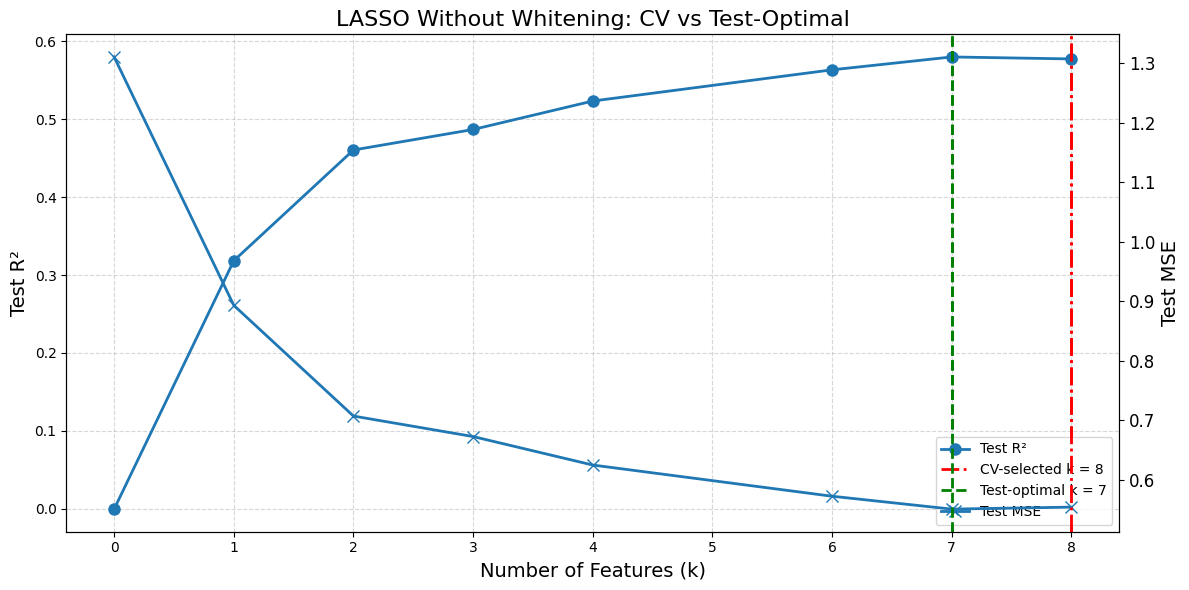

In [ ]:
# -------------------------------
# Experiment Case 1: Lasso Without ZCA Whitening
# -------------------------------

# Load data
df = pd.DataFrame(fetch_california_housing(as_frame=True).frame)
X = df.drop(columns='MedHouseVal')
y = df['MedHouseVal'].reset_index(drop=True)
feature_names = X.columns.tolist()

# Prepare train/test split and standardize
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
scaler_X      = StandardScaler().fit(X_train)
X_train_scaled = scaler_X.transform(X_train)
X_test_scaled  = scaler_X.transform(X_test)

scaler_y      = StandardScaler().fit(y_train.values.reshape(-1,1))
y_train_scaled = scaler_y.transform(y_train.values.reshape(-1,1)).flatten()
y_test_scaled  = scaler_y.transform(y_test.values.reshape(-1,1)).flatten()

# -------------------------------
# LassoCV on standardized data
# -------------------------------
lasso_cv = LassoCV(cv=5, random_state=42).fit(
    X_train_scaled, y_train_scaled
)
alphas     = lasso_cv.alphas_
cv_mse_list = np.mean(lasso_cv.mse_path_, axis=1)  # CV MSE per alpha

# Evaluate each alpha on the test set
k_list, r2_list, mse_list = [], [], []
for alpha in alphas:
    model = Lasso(alpha=alpha, max_iter=10000).fit(
        X_train_scaled, y_train_scaled
    )
    y_pred_scaled = model.predict(X_test_scaled)
    y_pred        = scaler_y.inverse_transform(
                        y_pred_scaled.reshape(-1,1)
                    ).flatten()

    k   = np.sum(model.coef_ != 0)
    r2  = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    k_list.append(k)
    r2_list.append(r2)
    mse_list.append(mse)

# -------------------------------
# Build grouped summary
# -------------------------------
lasso_df = pd.DataFrame({
    'k':        k_list,
    'Test R²':  r2_list,
    'Test MSE': mse_list,
    'CV MSE':   cv_mse_list
})
lasso_grouped = lasso_df.groupby('k').mean().reset_index()

# -------------------------------
# CV-based selection
# -------------------------------
optimal_k = np.sum(lasso_cv.coef_ != 0)
selected_features_cv = [
    feature_names[i]
    for i, coef in enumerate(lasso_cv.coef_)
    if coef != 0
]
cv_row      = lasso_grouped[lasso_grouped['k'] == optimal_k]
test_r2_cv  = cv_row['Test R²'].iloc[0]
test_mse_cv = cv_row['Test MSE'].iloc[0]

# -------------------------------
# Test-optimal selection (lowest Test MSE)
# -------------------------------
best_k_test_row = lasso_grouped.loc[
    lasso_grouped['Test MSE'].idxmin()
]
best_k_test = int(best_k_test_row['k'])
best_r2      = best_k_test_row['Test R²']
best_mse     = best_k_test_row['Test MSE']

# Refit on best alpha to get features
best_alpha = alphas[np.argmin(mse_list)]
lasso_test = Lasso(alpha=best_alpha, max_iter=10000).fit(
    X_train_scaled, y_train_scaled
)
selected_features_test = [
    feature_names[i]
    for i, coef in enumerate(lasso_test.coef_)
    if coef != 0
]

# -------------------------------
# Print Results
# -------------------------------
print("─" * 80)
print("Experiment Case 1: LASSO Without ZCA Whitening")
print("─" * 80)
print(f"Total predictors: p = {X.shape[1]}")
print("─" * 80)

print("CV-selected model performance on test set:")
print(f"  k = {optimal_k}")
print("  Selected Features:", selected_features_cv)
print(f"  Test R² = {test_r2_cv:.4f}")
print(f"  Test MSE = {test_mse_cv:.4f}")
print(f"  Optimal alpha (CV) = {lasso_cv.alpha_:.6f}")
print("─" * 80)

print("Test-optimal model performance on test set:")
print(f"  k = {best_k_test}")
print("  Selected Features:", selected_features_test)
print(f"  Test R² = {best_r2:.4f}")
print(f"  Test MSE = {best_mse:.4f}")
print(f"  Best alpha (test) = {best_alpha:.6f}")
print("─" * 80)

print("Grouped Evaluation by Number of Selected Features (k):\n")
print(
    lasso_grouped.to_string(
        index=False,
        columns=['k','Test R²','Test MSE','CV MSE']
    )
)
print()
print(f"Best CV-based k = {optimal_k} (Given by Minimum Avg. CV MSE = {cv_mse:.4f})")
print(f"Best Test-based k = {best_k_test} (Given by Minimum Test MSE = {best_mse:.4f})")
print("─" * 100)

# -------------------------------
# Plot R² & MSE vs k
# -------------------------------
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.set_xlabel('Number of Features (k)', fontsize=14)
ax1.set_ylabel('Test R²', fontsize=14)
ax1.plot(
    lasso_grouped['k'], lasso_grouped['Test R²'],
    marker='o', linewidth=2, markersize=8, label='Test R²'
)
ax1.axvline(optimal_k, color='red', linestyle='-.', linewidth=2,
            label=f'CV-selected k = {optimal_k}')
ax1.axvline(best_k_test, color='green', linestyle='--', linewidth=2,
            label=f'Test-optimal k = {best_k_test}')
ax1.grid(True, linestyle='--', alpha=0.5)

ax2 = ax1.twinx()
ax2.set_ylabel('Test MSE', fontsize=14)
ax2.plot(
    lasso_grouped['k'], lasso_grouped['Test MSE'],
    marker='x', linewidth=2, markersize=8, label='Test MSE'
)
ax2.axvline(optimal_k, color='red', linestyle='-.', linewidth=2)
ax2.axvline(best_k_test, color='green', linestyle='--', linewidth=2)
ax2.tick_params(labelsize=12)

plt.title('LASSO Without Whitening: CV vs Test-Optimal', fontsize=16)
fig.tight_layout()

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(
    lines1 + lines2, labels1 + labels2,
    loc='lower right'
)
plt.show()


────────────────────────────────────────────────────────────────────────────────────────────────────
Experiment Case 2: LASSO With ZCA Whitening
────────────────────────────────────────────────────────────────────────────────────────────────────
Total predictors: p = 8
────────────────────────────────────────────────────────────────────────────────────────────────────
CV‐selected model performance on test set:
  k = 8
  Selected Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
  Test R² = 0.5770
  Test MSE = 0.5543
  Optimal alpha (CV) = 0.000693
────────────────────────────────────────────────────────────────────────────────────────────────────
Test‐optimal model performance on test set:
  k = 6
  Selected Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveOccup', 'Latitude', 'Longitude']
  Test R² = 0.5802
  Test MSE = 0.5501
  Best alpha (test) = 0.016009
───────────────────────────────────────────────────────────────────────

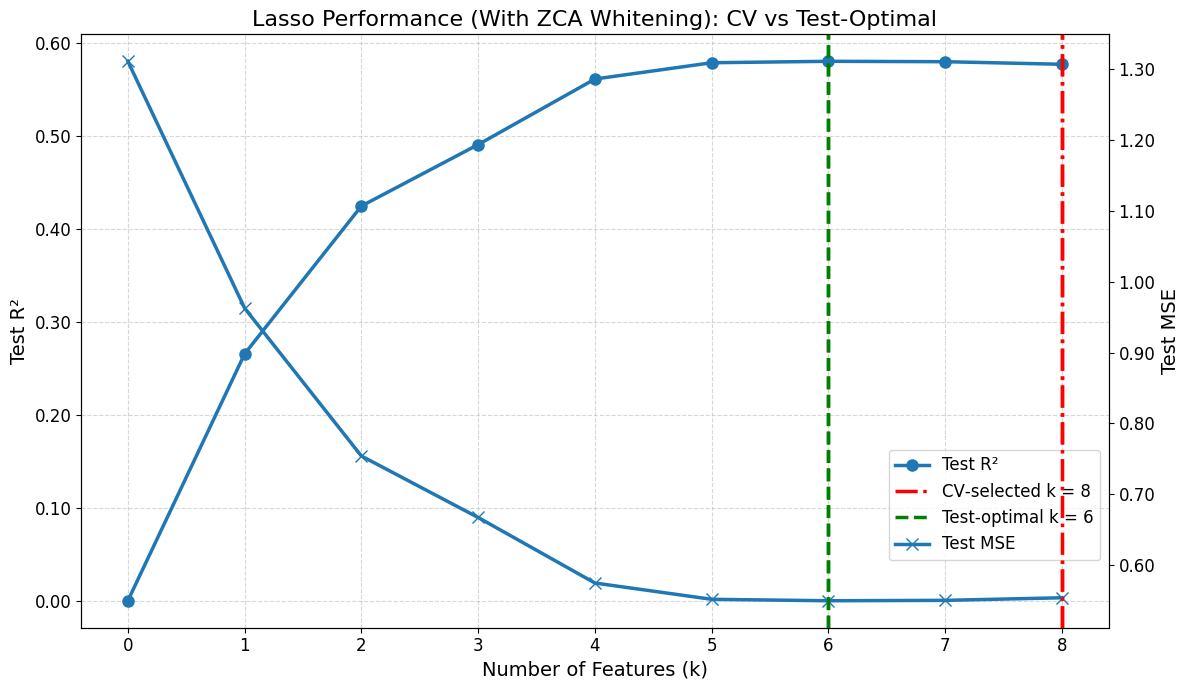

In [ ]:
# -------------------------------
# Experiment Case 2: Lasso with ZCA Whitening
# -------------------------------

# -------------------------------
# Load dataset and define features/target
# -------------------------------
df = pd.DataFrame(fetch_california_housing(as_frame=True).frame)
X = df.drop(columns='MedHouseVal')
y = df['MedHouseVal'].reset_index(drop=True)
feature_names = X.columns.tolist()

# -------------------------------
# ZCA Whitening Functions
# -------------------------------
def compute_zca_matrix(X_train):
    X_centered = X_train - np.mean(X_train, axis=0)
    cov = np.cov(X_centered, rowvar=False)
    U, S, _ = np.linalg.svd(cov)
    epsilon = 1e-5
    ZCA_matrix = U @ np.diag(1.0 / np.sqrt(S + epsilon)) @ U.T
    return ZCA_matrix, np.mean(X_train, axis=0)

def apply_zca(X, ZCA_matrix, mean_vec):
    return (X - mean_vec) @ ZCA_matrix

# -------------------------------
# Prepare Data
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler_X = StandardScaler().fit(X_train)
X_train_scaled = scaler_X.transform(X_train)
X_test_scaled  = scaler_X.transform(X_test)

ZCA_matrix, mean_vec    = compute_zca_matrix(X_train_scaled)
X_train_zca             = apply_zca(X_train_scaled, ZCA_matrix, mean_vec)
X_test_zca              = apply_zca(X_test_scaled,  ZCA_matrix, mean_vec)

scaler_y      = StandardScaler().fit(y_train.values.reshape(-1, 1))
y_train_scaled = scaler_y.transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled  = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# -------------------------------
# LassoCV on whitened training data
# -------------------------------
lasso_cv = LassoCV(cv=5, random_state=42).fit(X_train_zca, y_train_scaled)
alphas    = lasso_cv.alphas_

# Compute CV MSE per alpha (mean across folds)
cv_mse_list = np.mean(lasso_cv.mse_path_, axis=1)

# For each alpha, evaluate on test set and record metrics
k_list, r2_list, mse_list = [], [], []
for alpha in alphas:
    model = Lasso(alpha=alpha, max_iter=10000).fit(
        X_train_zca, y_train_scaled
    )
    y_pred_scaled = model.predict(X_test_zca)
    y_pred        = scaler_y.inverse_transform(
                        y_pred_scaled.reshape(-1,1)
                    ).flatten()

    k   = np.sum(model.coef_ != 0)
    r2  = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    k_list.append(k)
    r2_list.append(r2)
    mse_list.append(mse)

# -------------------------------
# Build grouped summary
# -------------------------------
lasso_df = pd.DataFrame({
    'k':        k_list,
    'Test R²':  r2_list,
    'Test MSE': mse_list,
    'CV MSE':   cv_mse_list
})
lasso_grouped = lasso_df.groupby('k').mean().reset_index()
cv_mse = lasso_grouped.loc[
    lasso_grouped['k'] == optimal_k,
    'CV MSE'
].iloc[0]

# -------------------------------
# CV-based Selection
# -------------------------------
optimal_k = np.sum(lasso_cv.coef_ != 0)
selected_features_cv = [
    feature_names[i]
    for i, coef in enumerate(lasso_cv.coef_)
    if coef != 0
]
cv_row       = lasso_grouped[lasso_grouped['k'] == optimal_k]
test_r2_cv   = cv_row['Test R²'].iloc[0]
test_mse_cv  = cv_row['Test MSE'].iloc[0]

# -------------------------------
# Test-based Selection (lowest Test MSE)
# -------------------------------
best_k_test_row = lasso_grouped.loc[
    lasso_grouped['Test MSE'].idxmin()
]
best_k_test = int(best_k_test_row['k'])
best_r2      = best_k_test_row['Test R²']
best_mse     = best_k_test_row['Test MSE']

# Re-fit on best alpha for feature names
best_alpha = alphas[np.argmin(mse_list)]
lasso_test = Lasso(alpha=best_alpha, max_iter=10000).fit(
    X_train_zca, y_train_scaled
)
selected_features_test = [
    feature_names[i]
    for i, coef in enumerate(lasso_test.coef_)
    if coef != 0
]

# -------------------------------
# Print Results
# -------------------------------
print("─" * 100)
print("Experiment Case 2: LASSO With ZCA Whitening")
print("─" * 100)
print(f"Total predictors: p = {X.shape[1]}")
print("─" * 100)

print("CV‐selected model performance on test set:")
print(f"  k = {optimal_k}")
print("  Selected Features:", selected_features_cv)
print(f"  Test R² = {test_r2_cv:.4f}")
print(f"  Test MSE = {test_mse_cv:.4f}")
print(f"  Optimal alpha (CV) = {lasso_cv.alpha_:.6f}")
print("─" * 100)

print("Test‐optimal model performance on test set:")
print(f"  k = {best_k_test}")
print("  Selected Features:", selected_features_test)
print(f"  Test R² = {best_r2:.4f}")
print(f"  Test MSE = {best_mse:.4f}")
print(f"  Best alpha (test) = {best_alpha:.6f}")
print("─" * 100)

print("Grouped Evaluation by Number of Selected Features (k):\n")
print(
    lasso_grouped.to_string(
        index=False,
        columns=['k','Test R²','Test MSE','CV MSE']
    )
)
print()
print(f"Best CV-based k = {optimal_k} ( Given by Minimum CV MSE = {cv_mse:.4f})")
print(f"Best Test-based k = {best_k_test} (Given by Minimum Test MSE = {best_mse:.4f})")
print("─" * 100)

# -------------------------------
# Plot R² & MSE vs k
# -------------------------------
fig, ax1 = plt.subplots(figsize=(12, 7))

ax1.set_xlabel('Number of Features (k)', fontsize=14)
ax1.set_ylabel('Test R²', fontsize=14)
ax1.plot(
    lasso_grouped['k'], lasso_grouped['Test R²'],
    marker='o', linewidth=2.5, markersize=8, label='Test R²'
)
ax1.axvline(optimal_k, color='red', linestyle='-.', linewidth=2.5,
            label=f'CV‐selected k = {optimal_k}')
ax1.axvline(best_k_test, color='green', linestyle='--', linewidth=2.5,
            label=f'Test‐optimal k = {best_k_test}')
ax1.tick_params(labelsize=12)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.grid(True, linestyle='--', alpha=0.5)

ax2 = ax1.twinx()
ax2.set_ylabel('Test MSE', fontsize=14)
ax2.plot(
    lasso_grouped['k'], lasso_grouped['Test MSE'],
    marker='x', linewidth=2.5, markersize=8, label='Test MSE'
)
ax2.axvline(optimal_k, color='red', linestyle='-.', linewidth=2.5)
ax2.axvline(best_k_test, color='green', linestyle='--', linewidth=2.5)
ax2.tick_params(labelsize=12)
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.title("Lasso Performance (With ZCA Whitening): CV vs Test‐Optimal", fontsize=16)
fig.tight_layout()

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(
    lines1 + lines2, labels1 + labels2,
    loc='lower right', bbox_to_anchor=(1, 0.1), fontsize=12
)

plt.show()


────────────────────────────────────────────────────────────────────────────────────────────────────
Experiment Case 1: MIQP-L₀ without ZCA Whitening - Test results on CV-based Selection vs Test-based Selection
────────────────────────────────────────────────────────────────────────────────────────────────────
Total predictors: p = 8
────────────────────────────────────────────────────────────────────────────────────────────────────
CV-selected model performance on test set:
  k = 7
  Selected features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'AveOccup', 'Latitude', 'Longitude']
  Test R² = 0.5758
  Test MSE = 0.5559
────────────────────────────────────────────────────────────────────────────────────────────────────
Test‐optimal model performance on test set:
  k = 4
  Selected features: ['MedInc', 'HouseAge', 'Latitude', 'Longitude']
  Test R² = 0.5810
  Test MSE = 0.5490
────────────────────────────────────────────────────────────────────────────────────────────────────
Group

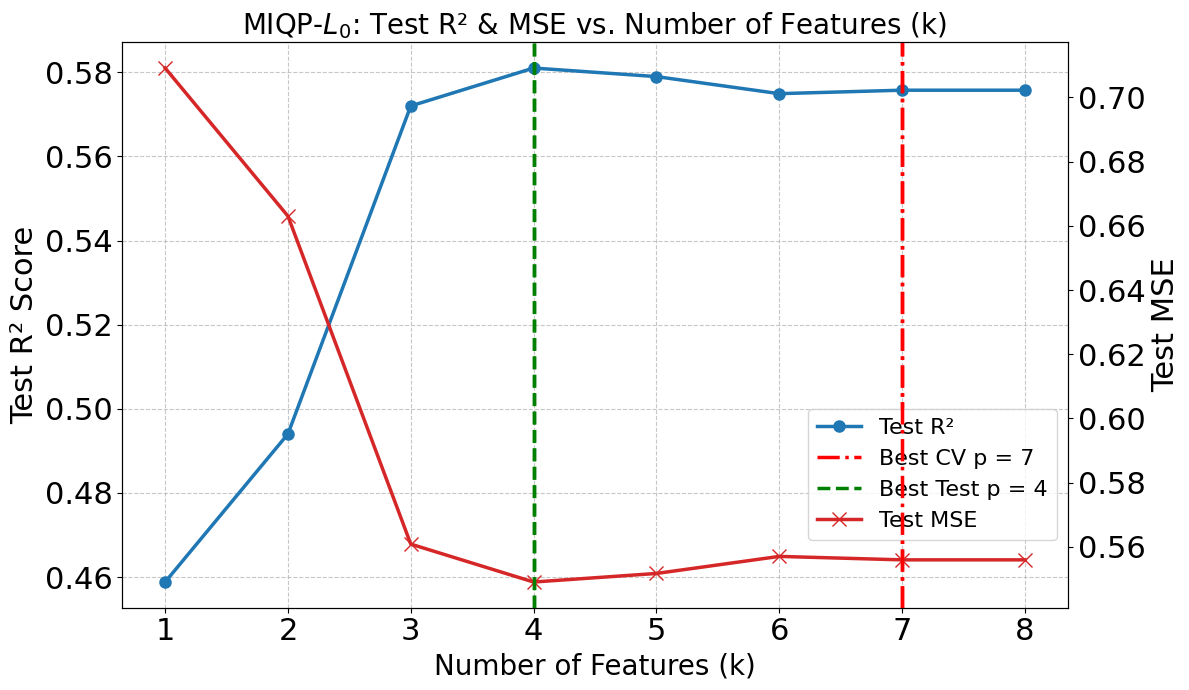

In [ ]:
# Experiment Case 1: MIQP-L0 (Best Subset Selection) Without ZCA Whitening

# -------------------------------
# Step 1: Load and preprocess data
# -------------------------------
df = pd.DataFrame(fetch_california_housing(as_frame=True).frame)
X = df.drop(columns='MedHouseVal')
y = df['MedHouseVal'].reset_index(drop=True)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.2, random_state=42)
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

X_train_mat = X_train_scaled
X_test_mat = X_test_scaled
y_train_true = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_test_true = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

n_train, p = X_train_mat.shape
M = 50  # Big-M constant

# -------------------------------
# Step 2: Cross-validation to select best k
# -------------------------------
def cross_validate_k(k, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    mse_scores = []

    for train_idx, val_idx in kf.split(X_train_mat):
        X_tr, X_val = X_train_mat[train_idx], X_train_mat[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        y_val_true = scaler_y.inverse_transform(y_val.reshape(-1, 1)).flatten()

        model = Model(f"CV_MIP_k{k}")
        model.setParam('OutputFlag', 0)

        beta = model.addVars(p, lb=-GRB.INFINITY, name="beta")
        z = model.addVars(p, vtype=GRB.BINARY, name="z")

        mse_expr = QuadExpr()
        for i in range(len(X_tr)):
            expr = quicksum(X_tr[i, j] * beta[j] for j in range(p))
            diff = y_tr[i] - expr
            mse_expr.add(diff * diff)
        mse_expr /= len(X_tr)
        model.setObjective(mse_expr, GRB.MINIMIZE)

        for j in range(p):
            model.addConstr(beta[j] <= M * z[j])
            model.addConstr(beta[j] >= -M * z[j])
        model.addConstr(quicksum(z[j] for j in range(p)) <= k)

        model.optimize()

        beta_vals = np.array([beta[j].X if z[j].X > 0.5 else 0 for j in range(p)])
        y_val_pred_scaled = X_val @ beta_vals
        y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled.reshape(-1, 1)).flatten()
        mse_val = mean_squared_error(y_val_true, y_val_pred)

        mse_scores.append(mse_val)

    return np.mean(mse_scores)

cv_results = {}
for k in range(1, p + 1):
    avg_mse = cross_validate_k(k)
    cv_results[k] = avg_mse
    #print(f"k={k:2d} | CV MSE={avg_mse:.4f}")

best_k_cv = min(cv_results, key=cv_results.get)
#print("\nCross-validation complete.")
#print(f"Best k selected by CV = {best_k_cv}")
#print(f"CV MSE at best k = {cv_results[best_k_cv]:.4f}")

# -------------------------------
# Step 3: Evaluate all k on full train/test set
# -------------------------------
def evaluate_k(k):
    model = Model(f"Final_MIP_k{k}")
    model.setParam('OutputFlag', 0)

    beta = model.addVars(p, lb=-GRB.INFINITY, name="beta")
    z = model.addVars(p, vtype=GRB.BINARY, name="z")

    mse_expr = QuadExpr()
    for i in range(n_train):
        expr = quicksum(X_train_mat[i, j] * beta[j] for j in range(p))
        diff = y_train[i] - expr
        mse_expr.add(diff * diff)
    mse_expr /= n_train
    model.setObjective(mse_expr, GRB.MINIMIZE)

    for j in range(p):
        model.addConstr(beta[j] <= M * z[j])
        model.addConstr(beta[j] >= -M * z[j])
    model.addConstr(quicksum(z[j] for j in range(p)) <= k)

    model.optimize()

    beta_vals = np.array([beta[j].X if z[j].X > 0.5 else 0 for j in range(p)])
    selected_indices = [j for j in range(p) if z[j].X > 0.5]
    selected_features = [X.columns[j] for j in selected_indices]

    y_train_pred = scaler_y.inverse_transform((X_train_mat @ beta_vals).reshape(-1, 1)).flatten()
    y_test_pred = scaler_y.inverse_transform((X_test_mat @ beta_vals).reshape(-1, 1)).flatten()

    r2_train = r2_score(y_train_true, y_train_pred)
    mse_train = mean_squared_error(y_train_true, y_train_pred)
    r2_test = r2_score(y_test_true, y_test_pred)
    mse_test = mean_squared_error(y_test_true, y_test_pred)

    return r2_train, mse_train, r2_test, mse_test, selected_features

r2_scores_train = []
mse_scores_train = []
r2_scores_test = []
mse_scores_test = []
selected_features_all = {}
k_values = range(1, p + 1)

for k in k_values:
    r2_train, mse_train, r2_test, mse_test, selected_features = evaluate_k(k)
    r2_scores_train.append(r2_train)
    mse_scores_train.append(mse_train)
    r2_scores_test.append(r2_test)
    mse_scores_test.append(mse_test)
    selected_features_all[k] = selected_features
    #print(f"k={k:2d} | Train R²={r2_train:.4f} | Test R²={r2_test:.4f} | Train MSE={mse_train:.4f} | Test MSE={mse_test:.4f}")

# -------------------------------
# Step 4: Compare CV-based and Test-optimal k
# -------------------------------
miqp_df = pd.DataFrame({
    'k': list(k_values),
    'Test R²': r2_scores_test,
    'Test MSE': mse_scores_test,
    'CV MSE': [cv_results[k] for k in k_values]
})

# Find best test‐optimal k
best_k_test_row = miqp_df.loc[miqp_df['Test MSE'].idxmin()]
best_k_test = int(best_k_test_row['k'])

# Selected features
selected_features_cv = selected_features_all[best_k_cv]
selected_features_test = selected_features_all[best_k_test]

print("─" * 100)
print("Experiment Case 1: MIQP-L₀ without ZCA Whitening - Test results on CV-based Selection vs Test-based Selection")
print("─" * 100)
print(f"Total predictors: p = {p}")
print("─" * 100)

# CV-based performance
print("CV-selected model performance on test set:")
print(f"  k = {best_k_cv}")
print("  Selected features:", selected_features_cv)
print(f"  Test R² = {miqp_df.loc[miqp_df['k'] == best_k_cv, 'Test R²'].values[0]:.4f}")
print(f"  Test MSE = {miqp_df.loc[miqp_df['k'] == best_k_cv, 'Test MSE'].values[0]:.4f}")
print("─" * 100)

# Test-optimal performance
print("Test‐optimal model performance on test set:")
print(f"  k = {best_k_test}")
print("  Selected features:", selected_features_test)
print(f"  Test R² = {best_k_test_row['Test R²']:.4f}")
print(f"  Test MSE = {best_k_test_row['Test MSE']:.4f}")
print("─" * 100)

# Combined table
print("Grouped Evaluation by Number of Selected Features (k):\n")
print(miqp_df.to_string(index=False))
print(f"Best CV-based k = {best_k_cv} (CV MSE = {cv_results[best_k_cv]:.4f})")
print(f"Best Test-based k = {best_k_test} (Test MSE = {best_k_test_row['Test MSE']:.4f})")
print("─" * 100)

# -------------------------------
# Step 5: Plot test R² & MSE vs k
# -------------------------------
fig, ax1 = plt.subplots(figsize=(12, 7))

label_fontsize = 22
tick_fontsize = 22
title_fontsize = 20
axis_label_fontsize = 20

# R² (left)
ax1.set_xlabel('Number of Features (k)', fontsize=axis_label_fontsize)
ax1.set_ylabel('Test R² Score', fontsize=label_fontsize)

test_r2_line, = ax1.plot(
    k_values, r2_scores_test,
    color='tab:blue', marker='o', markersize=8, linewidth=2.5, label='Test R²'
)
ax1.axvline(best_k_cv, color='red', linestyle='-.', linewidth=2.5, label=f'Best CV p = {best_k_cv}')
ax1.axvline(best_k_test, color='green', linestyle='--', linewidth=2.5, label=f'Best Test p = {best_k_test}')
ax1.tick_params(axis='y', labelsize=tick_fontsize)
ax1.tick_params(axis='x', labelsize=tick_fontsize)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# MSE (right)
ax2 = ax1.twinx()
ax2.set_ylabel('Test MSE', fontsize=label_fontsize)
test_mse_line, = ax2.plot(
    k_values, mse_scores_test,
    color='tab:red', marker='x', markersize=10, linewidth=2.5, label='Test MSE'
)
ax2.axvline(best_k_cv, color='red', linestyle='-.', linewidth=2.5)
ax2.axvline(best_k_test, color='green', linestyle='--', linewidth=2.5)
ax2.tick_params(axis='y', labelsize=tick_fontsize)
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# Title and legend
plt.title('MIQP-$L_0$: Test R² & MSE vs. Number of Features (k)', fontsize=title_fontsize)
ax1.grid(True, linestyle='--', alpha=0.7)
fig.tight_layout()

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(
    lines1 + lines2, labels1 + labels2,
    loc='lower right', bbox_to_anchor=(1, 0.10),
    fontsize=16, frameon=True
)

plt.show()


────────────────────────────────────────────────────────────────────────────────────────────────────
Experiment Case 2: MIQP-L₀ with ZCA Whitening - Test results on CV-based Selection vs Test-based Selection
────────────────────────────────────────────────────────────────────────────────────────────────────
Total predictors: k = 8
────────────────────────────────────────────────────────────────────────────────────────────────────
CV-selected model performance on test set:
  k = 6
  Selected features: ['MedInc', 'HouseAge', 'AveRooms', 'AveOccup', 'Latitude', 'Longitude']
  Test R² = 0.5801
  Test MSE = 0.5503
────────────────────────────────────────────────────────────────────────────────────────────────────
Test‐optimal model performance on test set:
  k = 6
  Selected features: ['MedInc', 'HouseAge', 'AveRooms', 'AveOccup', 'Latitude', 'Longitude']
  Test R² = 0.5801
  Test MSE = 0.5503
──────────────────────────────────────────────────────────────────────────────────────────────────

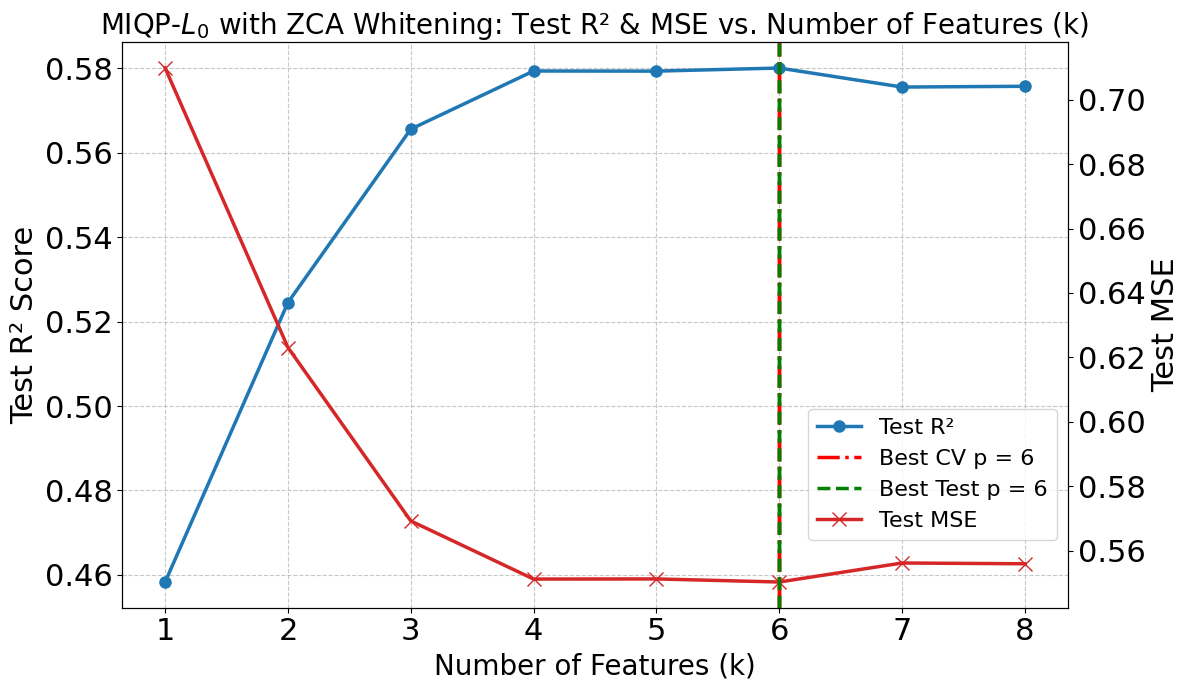

In [ ]:
# Experiment Case 2: MIQP-L0 (Best Subset Selection) with ZCA Whitening

# -------------------------------
# ZCA Whitening functions
# -------------------------------
def compute_zca_matrix(X):
    X_centered = X - np.mean(X, axis=0)
    cov = np.cov(X_centered, rowvar=False)
    U, S, _ = np.linalg.svd(cov)
    epsilon = 1e-5
    ZCA_matrix = U @ np.diag(1.0 / np.sqrt(S + epsilon)) @ U.T
    return ZCA_matrix, np.mean(X, axis=0)

def apply_zca(X, ZCA_matrix, mean_vec):
    return (X - mean_vec) @ ZCA_matrix

# -------------------------------
# Load and preprocess data
# -------------------------------
df = pd.DataFrame(fetch_california_housing(as_frame=True).frame)
X_df = df.drop(columns='MedHouseVal')  # keep as DataFrame for feature names
X = X_df.values
y = df['MedHouseVal'].values

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.2, random_state=42)

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

ZCA_matrix, mean_vec = compute_zca_matrix(X_train_scaled)
X_train_mat = apply_zca(X_train_scaled, ZCA_matrix, mean_vec)
X_test_mat = apply_zca(X_test_scaled, ZCA_matrix, mean_vec)

y_train_true = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_test_true = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

n_train, p = X_train_mat.shape
M = 50

# -------------------------------
# Cross-validation to select best k
# -------------------------------
def cross_validate_k(k, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    mse_scores = []

    for train_idx, val_idx in kf.split(X_train_mat):
        X_tr, X_val = X_train_mat[train_idx], X_train_mat[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        y_val_true = scaler_y.inverse_transform(y_val.reshape(-1, 1)).flatten()

        model = Model()
        model.setParam('OutputFlag', 0)

        beta = model.addVars(p, lb=-GRB.INFINITY, name="beta")
        z = model.addVars(p, vtype=GRB.BINARY, name="z")

        mse_expr = QuadExpr()
        for i in range(len(X_tr)):
            expr = quicksum(X_tr[i, j] * beta[j] for j in range(p))
            diff = y_tr[i] - expr
            mse_expr.add(diff * diff)
        mse_expr /= len(X_tr)
        model.setObjective(mse_expr, GRB.MINIMIZE)

        for j in range(p):
            model.addConstr(beta[j] <= M * z[j])
            model.addConstr(beta[j] >= -M * z[j])
        model.addConstr(quicksum(z[j] for j in range(p)) <= k)

        model.optimize()

        beta_vals = np.array([beta[j].X if z[j].X > 0.5 else 0 for j in range(p)])
        y_val_pred = scaler_y.inverse_transform((X_val @ beta_vals).reshape(-1, 1)).flatten()
        mse_val = mean_squared_error(y_val_true, y_val_pred)

        mse_scores.append(mse_val)

    return np.mean(mse_scores)

cv_results = {}
for k in range(1, p + 1):
    avg_mse = cross_validate_k(k)
    cv_results[k] = avg_mse
    #print(f"k={k:2d} | CV MSE={avg_mse:.4f}")

best_k_cv = min(cv_results, key=cv_results.get)

# -------------------------------
# Evaluate all k on test set
# -------------------------------
def evaluate_k(k):
    model = Model()
    model.setParam('OutputFlag', 0)

    beta = model.addVars(p, lb=-GRB.INFINITY, name="beta")
    z = model.addVars(p, vtype=GRB.BINARY, name="z")

    mse_expr = QuadExpr()
    for i in range(n_train):
        expr = quicksum(X_train_mat[i, j] * beta[j] for j in range(p))
        diff = y_train[i] - expr
        mse_expr.add(diff * diff)
    mse_expr /= n_train
    model.setObjective(mse_expr, GRB.MINIMIZE)

    for j in range(p):
        model.addConstr(beta[j] <= M * z[j])
        model.addConstr(beta[j] >= -M * z[j])
    model.addConstr(quicksum(z[j] for j in range(p)) <= k)

    model.optimize()

    beta_vals = np.array([beta[j].X if z[j].X > 0.5 else 0 for j in range(p)])
    selected_indices = [j for j in range(p) if z[j].X > 0.5]
    selected_features = [X_df.columns[j] for j in selected_indices]

    y_test_pred = scaler_y.inverse_transform((X_test_mat @ beta_vals).reshape(-1, 1)).flatten()
    r2_test = r2_score(y_test_true, y_test_pred)
    mse_test = mean_squared_error(y_test_true, y_test_pred)

    return r2_test, mse_test, selected_features

r2_scores_test = []
mse_scores_test = []
selected_features_all = {}
k_values = range(1, p + 1)

for k in k_values:
    r2_test, mse_test, selected_features = evaluate_k(k)
    r2_scores_test.append(r2_test)
    mse_scores_test.append(mse_test)
    selected_features_all[k] = selected_features
    #print(f"k={k:2d} | Test R²={r2_test:.4f} | Test MSE={mse_test:.4f}")

best_k_test = int(np.argmin(mse_scores_test) + 1)

# -------------------------------
# Step 4: Compare CV-based and Test-optimal k
# -------------------------------
miqp_df = pd.DataFrame({
    'k': list(k_values),
    'Test R²': r2_scores_test,
    'Test MSE': mse_scores_test,
    'CV MSE': [cv_results[k] for k in k_values]
})

# Find best test‐optimal k
best_k_test_row = miqp_df.loc[miqp_df['Test MSE'].idxmin()]
best_k_test = int(best_k_test_row['k'])

# Selected features
selected_features_cv = selected_features_all[best_k_cv]
selected_features_test = selected_features_all[best_k_test]

print("─" * 100)
print("Experiment Case 2: MIQP-L₀ with ZCA Whitening - Test results on CV-based Selection vs Test-based Selection")
print("─" * 100)
print(f"Total predictors: k = {p}")
print("─" * 100)

# CV-based performance
print("CV-selected model performance on test set:")
print(f"  k = {best_k_cv}")
print("  Selected features:", selected_features_cv)
print(f"  Test R² = {miqp_df.loc[miqp_df['k'] == best_k_cv, 'Test R²'].values[0]:.4f}")
print(f"  Test MSE = {miqp_df.loc[miqp_df['k'] == best_k_cv, 'Test MSE'].values[0]:.4f}")
print("─" * 100)

# Test-optimal performance
print("Test‐optimal model performance on test set:")
print(f"  k = {best_k_test}")
print("  Selected features:", selected_features_test)
print(f"  Test R² = {best_k_test_row['Test R²']:.4f}")
print(f"  Test MSE = {best_k_test_row['Test MSE']:.4f}")
print("─" * 100)

# Combined table
print("Grouped Evaluation by Number of Selected Features (k):\n")
print(miqp_df.to_string(index=False))
print(f"Best CV-based k = {best_k_cv} (Given by Minimum Avg. CV MSE = {cv_results[best_k_cv]:.4f})")
print(f"Best Test-based k = {best_k_test} (Given by Minimum Test MSE = {best_k_test_row['Test MSE']:.4f})")
print("─" * 100)

# -------------------------------
# Plot test performance
# -------------------------------
fig, ax1 = plt.subplots(figsize=(12, 7))

label_fontsize = 22
tick_fontsize = 22
title_fontsize = 20
axis_label_fontsize = 20

ax1.set_xlabel('Number of Features (k)', fontsize=axis_label_fontsize)
ax1.set_ylabel('Test R² Score', fontsize=label_fontsize)

test_r2_line, = ax1.plot(
    k_values, r2_scores_test,
    color='tab:blue', marker='o', markersize=8, linewidth=2.5, label='Test R²'
)
ax1.axvline(best_k_cv, color='red', linestyle='-.', linewidth=2.5, label=f'Best CV k = {best_k_cv}')
ax1.axvline(best_k_test, color='green', linestyle='--', linewidth=2.5, label=f'Best Test k = {best_k_test}')
ax1.tick_params(axis='y', labelsize=tick_fontsize)
ax1.tick_params(axis='x', labelsize=tick_fontsize)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax2 = ax1.twinx()
ax2.set_ylabel('Test MSE', fontsize=label_fontsize)
test_mse_line, = ax2.plot(
    k_values, mse_scores_test,
    color='tab:red', marker='x', markersize=10, linewidth=2.5, label='Test MSE'
)
ax2.axvline(best_k_cv, color='red', linestyle='-.', linewidth=2.5)
ax2.axvline(best_k_test, color='green', linestyle='--', linewidth=2.5)
ax2.tick_params(axis='y', labelsize=tick_fontsize)
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.title('MIQP-$L_0$ with ZCA Whitening: Test R² & MSE vs. Number of Features (k)', fontsize=title_fontsize)
ax1.grid(True, linestyle='--', alpha=0.7)
fig.tight_layout()

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(
    lines1 + lines2, labels1 + labels2,
    loc='lower right', bbox_to_anchor=(1, 0.10),
    fontsize=16, frameon=True
)

plt.show()


 k  Test R²  Test MSE  Penalized R²
 1 0.458309  0.709837      0.456309
 2 0.524526  0.623065      0.520526
 3 0.565610  0.569229      0.559610
 4 0.579385  0.551178      0.571385
 5 0.579352  0.551221      0.569352
 6 0.580085  0.550261      0.568085
 7 0.575579  0.556165      0.561579
 8 0.575761  0.555927      0.559761

Best sparse model at k = 4 (Penalized Test R² = 0.5714)


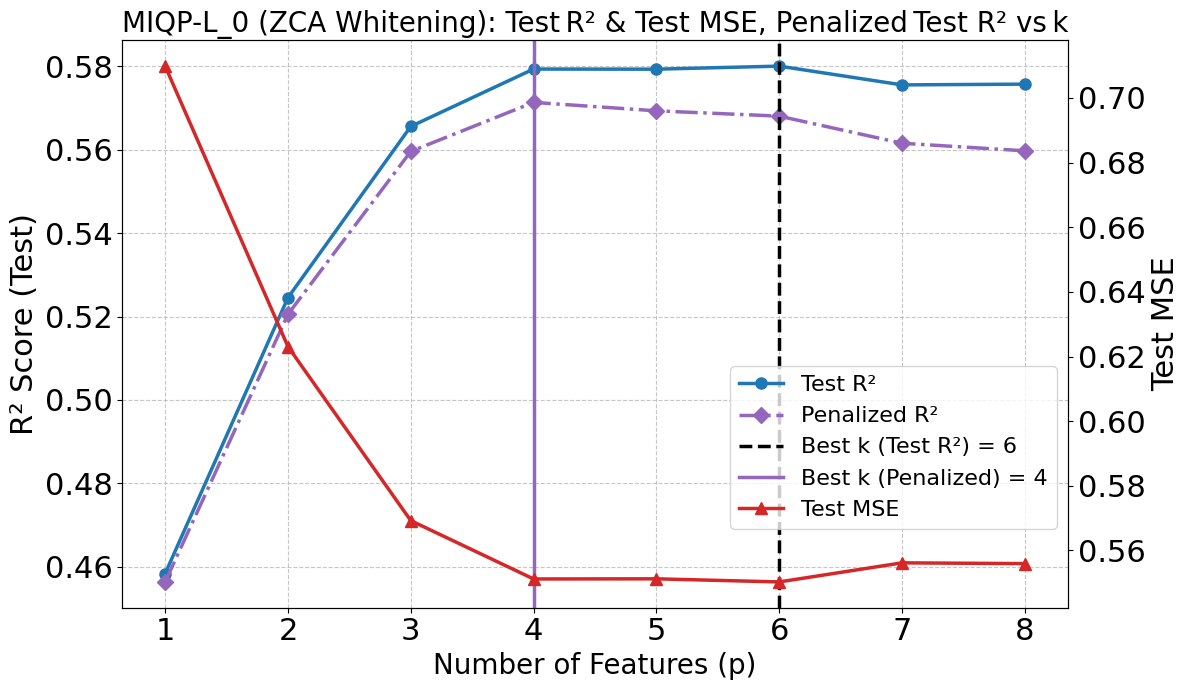

In [ ]:


# ──────────────────────────────────────────────────────────────────────────────
# 1) Compute Penalized R² and find best_k_penalized
# ──────────────────────────────────────────────────────────────────────────────
lambda_penalty = 0.002

penalized_scores = []
best_penalized = -np.inf
best_k_penalized = None

for k, r2 in zip(k_values, r2_scores_test):
    pen = r2 - lambda_penalty * k
    penalized_scores.append(pen)
    if pen > best_penalized:
        best_penalized = pen
        best_k_penalized = k

# Tabulate
df_pen = pd.DataFrame({
    'k':            k_values,
    'Test R²':      r2_scores_test,
    'Test MSE':     mse_scores_test,
    'Penalized R²': penalized_scores
})
print(df_pen.to_string(index=False, columns=['k','Test R²','Test MSE','Penalized R²']))
print(f"\nBest sparse model at k = {best_k_penalized} "
      f"(Penalized Test R² = {best_penalized:.4f})")


# ──────────────────────────────────────────────────────────────────────────────
# 2) Plot Test R², Penalized R² & Test MSE
# ──────────────────────────────────────────────────────────────────────────────
best_k_test = int(np.argmax(r2_scores_test) + 1)

fig, ax1 = plt.subplots(figsize=(12, 7))

# Fonts
axis_fs  = 20
label_fs = 22
tick_fs  = 22
title_fs = 20

# X & left Y axis
ax1.set_xlabel('Number of Features (p)', fontsize=axis_fs)
ax1.set_ylabel('R² Score (Test)', fontsize=label_fs)

# Plot Test R²
ax1.plot(k_values, r2_scores_test,
         color='tab:blue', marker='o', linewidth=2.5, markersize=8,
         label='Test R²')

# Plot Penalized R²
ax1.plot(k_values, penalized_scores,
         color='tab:purple', marker='D', linestyle='-.', linewidth=2.5, markersize=8,
         label='Penalized R²')

# Vertical lines
ax1.axvline(best_k_test,      color='black',  linestyle='--', linewidth=2.5,
            label=f'Best k (Test R²) = {best_k_test}')
ax1.axvline(best_k_penalized, color='tab:purple', linestyle='-', linewidth=2.5,
            label=f'Best k (Penalized) = {best_k_penalized}')

ax1.tick_params(axis='both', labelsize=tick_fs)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# Right Y axis for MSE
ax2 = ax1.twinx()
ax2.set_ylabel('Test MSE', fontsize=label_fs)
ax2.plot(k_values, mse_scores_test,
         color='tab:red', marker='^', linewidth=2.5, markersize=8,
         label='Test MSE')
ax2.tick_params(axis='y', labelsize=tick_fs)
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# Title, grid, legend
plt.title('MIQP-L_0 (ZCA Whitening): Test R² & Test MSE, Penalized Test R² vs k', fontsize=title_fs)
ax1.grid(True, linestyle='--', alpha=0.7)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(
    lines1 + lines2,
    labels1 + labels2,
    loc='lower right',
    bbox_to_anchor=(1, 0.12),   # ← moved up from 0.10 to 0.25
    fontsize=16,
    frameon=True
)
    

fig.tight_layout()
plt.show()


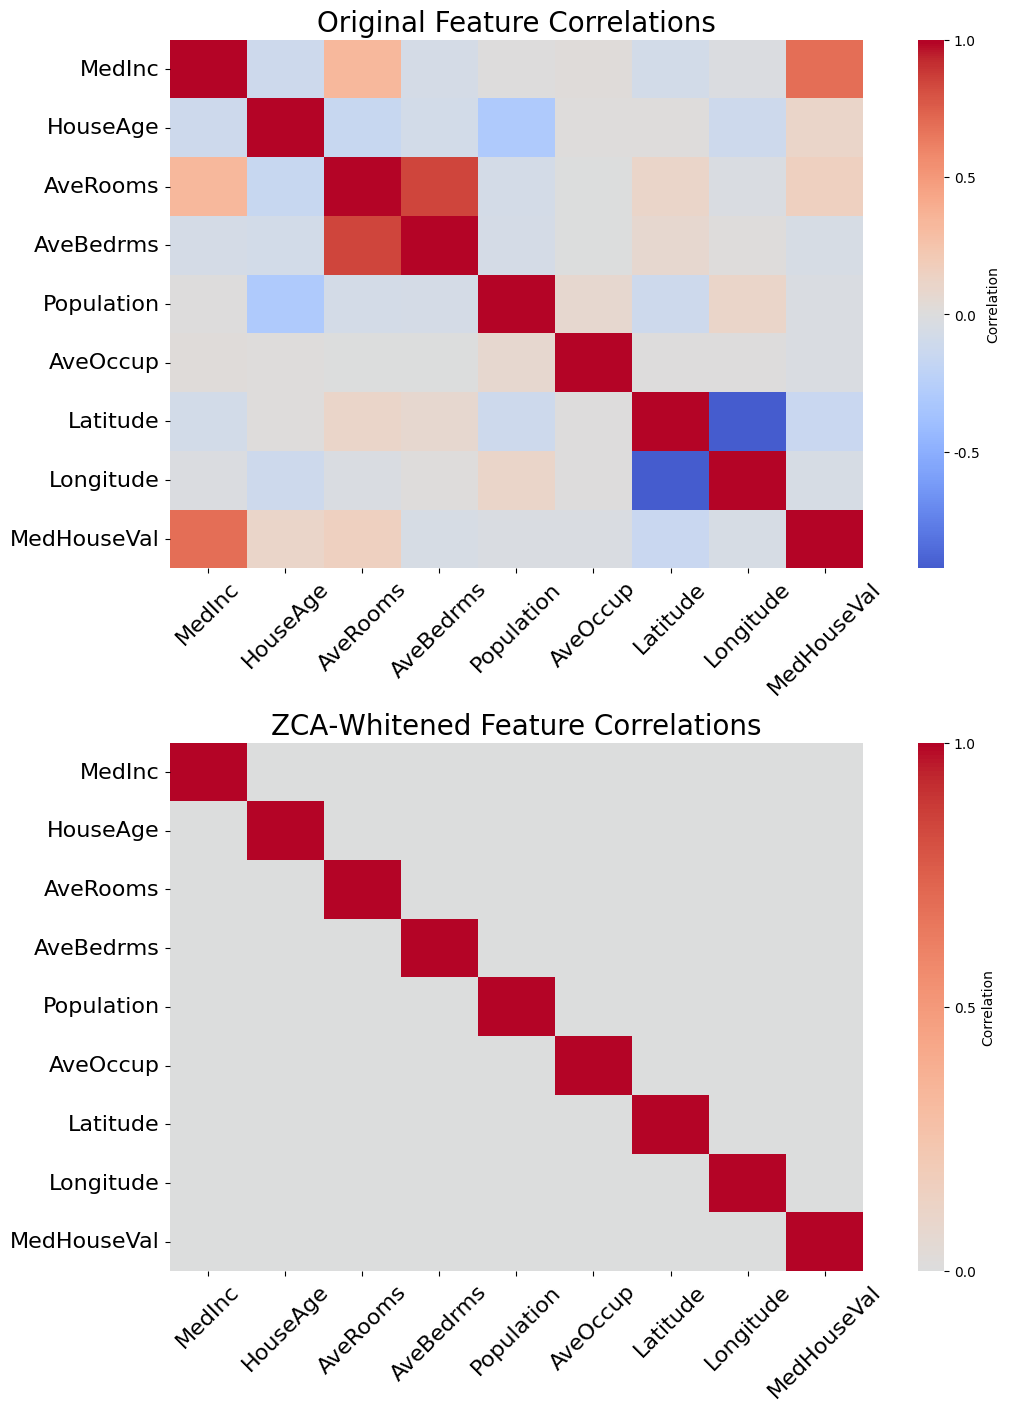

In [ ]:
# Correlation Matrix Heatmaps for Original and ZCA-Whitened Features
# -------------------------------
df = pd.DataFrame(fetch_california_housing(as_frame=True).frame)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

# ZCA whitening
def zca_whitening(X):
    X_centered = X - np.mean(X, axis=0)
    cov = np.cov(X_centered, rowvar=False)
    U, S, _ = np.linalg.svd(cov)
    epsilon = 1e-5
    ZCA = U @ np.diag(1.0/np.sqrt(S + epsilon)) @ U.T
    return X_centered @ ZCA

X_zca = zca_whitening(X_scaled)

# Prepare common tick settings
ticks      = np.linspace(-1, 1, 5)
tick_labels = [f"{t:.1f}" for t in ticks]

heatmap_kwargs = dict(
    cmap='coolwarm',
    center=0,
    annot=False,
    fmt=".2f"
)

# Make the figure with constrained_layout ON
fig, axs = plt.subplots(2, 1, figsize=(10, 14), constrained_layout=True)

# Top: original
sns.heatmap(
    pd.DataFrame(X_scaled, columns=df.columns).corr(),
    ax=axs[0],
    cbar_kws={'ticks': ticks, 'label': 'Correlation'},
    **heatmap_kwargs
)
axs[0].set_title('Original Feature Correlations', fontsize=20)
axs[0].tick_params(axis='x', labelsize=16, rotation=45)
axs[0].tick_params(axis='y', labelsize=16, rotation=0)
# apply tick labels
axs[0].collections[0].colorbar.ax.set_yticklabels(tick_labels)

# Bottom: ZCA‑whitened
sns.heatmap(
    pd.DataFrame(X_zca, columns=df.columns).corr(),
    ax=axs[1],
    cbar_kws={'ticks': ticks, 'label': 'Correlation'},
    **heatmap_kwargs
)
axs[1].set_title('ZCA‑Whitened Feature Correlations', fontsize=20)
axs[1].tick_params(axis='x', labelsize=16, rotation=45)
axs[1].tick_params(axis='y', labelsize=16, rotation=0)
# apply tick labels
axs[1].collections[0].colorbar.ax.set_yticklabels(tick_labels)

plt.show()
